### Phys 629, Fall 2023, University of Mississippi


# Lecture 23, Chapter 5: Bayesian Statistical Inference

Material in this lecture and notebook is based upon the Basic Stats portion of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), the Introduction to Probability & Statistics portion of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18), J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html), and Stephen R. Taylor (https://github.com/VanderbiltAstronomy/astr_8070_s22). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.
- [MCMC Sampling](https://twiecki.io/blog/2015/11/10/mcmc-sampling) by Thomas Wiecki.
- [Sampler, Samplers, Everywhere...](http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/) by Matt Pitkin.
- [MCMC Interactive Demo](https://chi-feng.github.io/mcmc-demo/app.html) by Chi Feng.

***Exercises required for class participation are in <font color='red'>red</font>.***

***BEFORE YOU START:*** Please pause for a few minutes and install these package `dynesty` before going through today's notebook. Make sure this notebook is in the correct Python kernel for the class conda environment before executing each of the following cells in turn. *(The second package you'll install below is just cython, which wraps C code in Python structures.)*

In [1]:
!pip3 install dynesty

In [2]:
!pip3 install cython

## Gibbs Sampling <a class="anchor" id="one"></a>

**Gibbs sampling** is an MCMC method that avoids acceptance-rejection techniques. Instead, one sweeps through each parameter (or block of parameters) to draw from their ***conditional probability distributions***, with all other parameters fixed to their current values. 

After sampling for a sufficiently large number of Gibbs steps, the principles of MCMC guarantee that **this process of sequential conditional probability drawing will converge to the joint posterior distribution of the overall model parameter space**. A standard Gibbs algorithm is shown below.

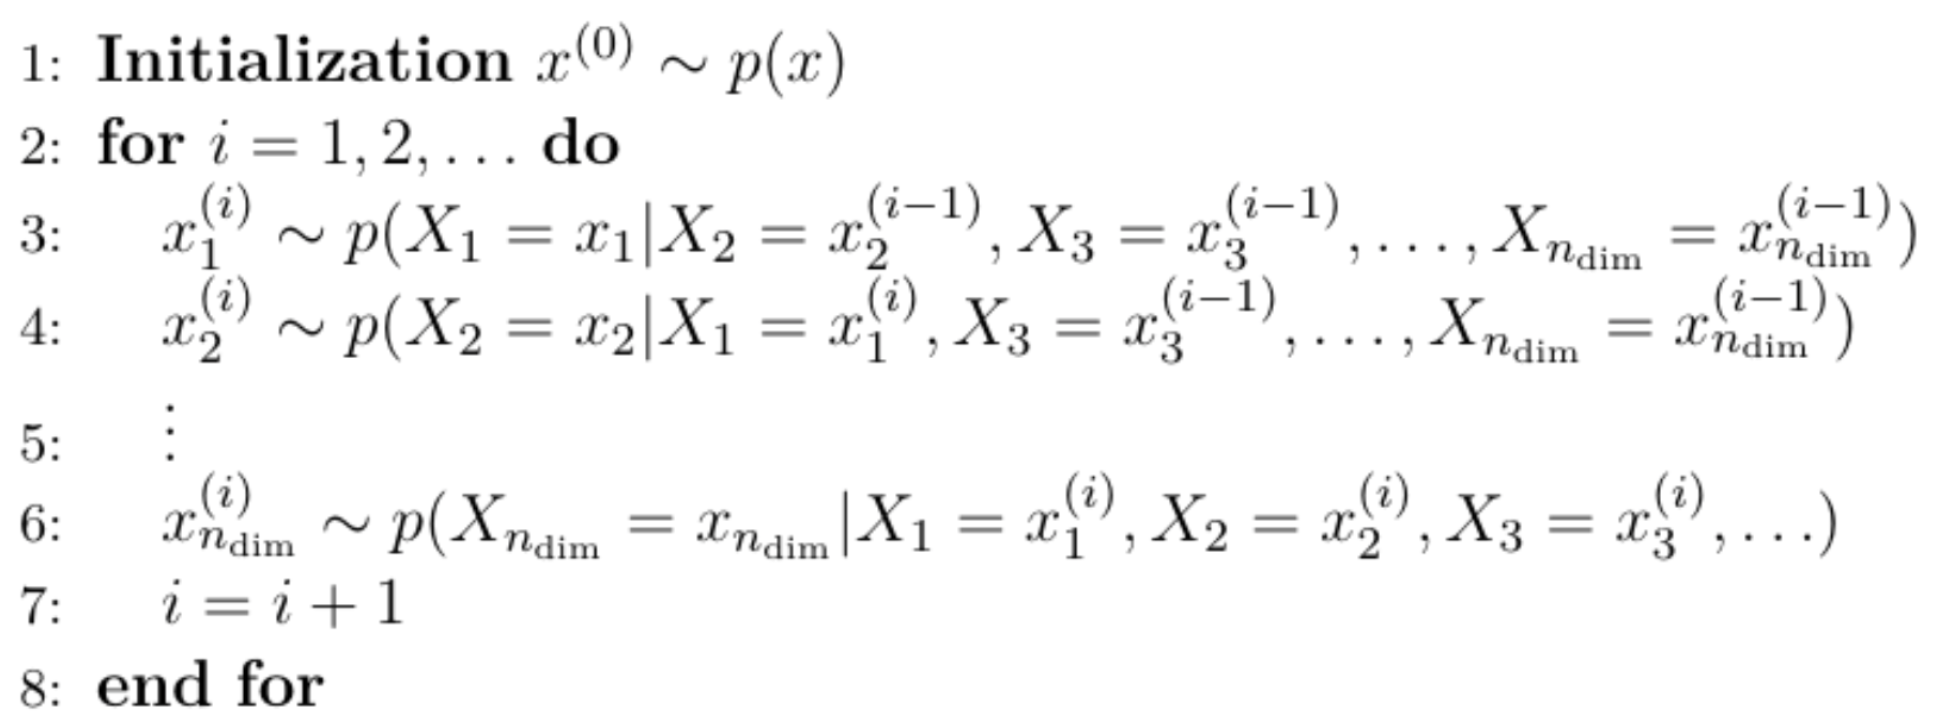

To break this algorithm up into words, we

- We initialize the sampler at some random point in parameter space.


- Fix all parameters except the first one. Draw a random value from the conditional posterior probability distribution of this first parameter **given** the fixed values of all other parameters.


- Fix all parameters except the second one. Draw a random value from the conditional posterior probability distribution of this second parameter **given** the fixed values of all other parameters **and the updated value of the first parameter**.


- *et cetera* for all parameters.


- Repeat for many Gibbs steps.



### Benefits of Gibbs Sampling <a class="anchor" id="onea"></a>

- By drawing directly from the posterior conditionals, the **auto-correlation length can be exceptionally small**, with **minimal burn-in**. 
- **It's also fast**; sequential draws directly from the parameter posterior conditionals means that we are not rejecting any points. 

### Drawbacks of Gibbs Sampling <a class="anchor" id="oneb"></a>

- You need to know the form of the conditional probability distributions for each parameter (or parameter blocks), and how to draw samples from it. 
- This can be a non-trivial problem, so typically a lot of effort is placed in manipulating the form of the posterior to find a conditional that is a standard probability distribution. This is where **conjugate priors** become really handy. 

### Conjugate Priors (Again) <a class="anchor" id="onec"></a>

> *These are parameter priors for which the the posterior lies in the same family of distributions as the prior.* 

***EXAMPLE***

- Imagine we have a Gaussian likelihood function with mean $\mu$ and variance $\sigma^2$ parameters. 
- The conjugate prior on $\mu$ when $\sigma^2$ is known (as is assumed in Gibbs when sweeping through each parameter) is a Gaussian distribution.
- Thus the conditional posterior distribution on $\mu$ is simply a Gaussian. 
- Similarly, the conjugate prior on $\sigma^2$ when $\mu$ is known is an inverse gamma distribution.
- Thus the conditional posterior distribution on $\sigma^2$ is an inverse gamma distribution.

#### Gibbs Approach

Code for this example is adapted from https://wiseodd.github.io/techblog/2015/10/09/gibbs-sampling/, https://bookdown.org/rdpeng/advstatcomp/gibbs-sampler.html, and https://www.wikiwand.com/en/Conjugate_prior. 

---

To make the Gibbs approach work, we need the conjugate priors for the mean and variance of a Gaussian likelihood. These are a Gaussian for the mean, and an inverse Gamma for the variance. We'll make these broad so that our posterior constraints are data-dominated.

$$ p(\mu) = \mathcal{N}(\mu_0,\sigma_0) = \frac{1}{\sqrt{2\pi\sigma_0^2}}\exp\left(\frac{-(\mu-\mu_0)^2}{2\sigma_0^2} \right)$$

where $\mu_0,\sigma_0$ are the location and scale parameters of the Gaussian prior on $\mu$, and 

$$ p(\sigma^2) = \mathrm{IG}(\alpha,\beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} (1/\sigma^2)^{\alpha+1}\exp(-\beta/\sigma^2)$$

where $\alpha,\beta$ are parameters defining the shape of the inverse Gamma prior on $\sigma^2$.

It is algebraically tedious and relatively straightforward to multiply the Gaussian likelihood of the data with each of these priors in turn to work out the posterior conditional distributions on $\mu$ and $\sigma^2$. These turn out to be

$$ p(\mu|\{x_i\}) = \mathcal{N}(\mu_*,\sigma_*)$$

where 

$$\mu_* = \left( \frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}\right)^{-1} \left(\frac{\mu_0}{\sigma_0^2} + \frac{\sum^n_{i=1}x_i}{\sigma^2} \right)$$

$$\sigma^2_* = \left( \frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}\right)^{-1} $$

and 

$$ p(\sigma^2|\{x_i\}) = \mathrm{IG}(\alpha_*,\beta_*)$$

where 

$$ \alpha_* = \alpha + n/2$$

$$ \beta_* = \beta + \frac{\sum^n_{i=1}(x_i-\mu)^2}{2}$$

In [3]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import acor
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [4]:
# conditional of \mu
def p_mu_given_sigma2(sigma2, x, mu0, sigma0):
    sigma_star2 = 1.0 / ( (1.0 / sigma0**2.) + (x.shape[0] / sigma2) )
    mu_star = sigma_star2 * ((mu0/sigma0**2.) + (np.sum(x)/sigma2))
    return np.random.normal(loc=mu_star, scale=np.sqrt(sigma_star2))

# conditional of \sigma^2
def p_sigma2_given_mu(mu, x, alpha, beta):
    alpha_star = alpha + x.shape[0]/2.
    beta_star = beta + np.sum((x-mu)**2.)/2.
    return stats.invgamma.rvs(a=alpha_star, scale=beta_star)

#iter = 2000 makes 2000 samples
def gibbs_sampling(data, mu_initial, sigma2_initial,
                   mu0, sigma0, alpha, beta, iter=2000):
    samples = np.zeros((iter, 2))
    samples[0,:] = [mu_initial, sigma2_initial]

    for ii in range(1,iter):
        # sequential sampling of posterior conditionals
        ### mu first
        mu_new = p_mu_given_sigma2(samples[ii-1,1], data, mu0, sigma0)
        samples[ii,0] = mu_new
        ### then sigma2
        sigma2_new = p_sigma2_given_mu(samples[ii,0], data, alpha, beta)
        samples[ii,1] = sigma2_new

    return samples

In [5]:
# Generate some data
np.random.seed(21)
Ndata = 100
mu = 1.0
sigma = 0.5 # assumed known 
data = stats.norm(mu, sigma).rvs(Ndata)

In [6]:
# starting point
mu_initial = 0.2
sigma2_initial = 0.6

# priors
mu0 = 1.0
sigma0 = 0.9
alpha = 1.0
beta = 1.0

## SAMPLE!
def run_gibbs():
    samples = gibbs_sampling(data, mu_initial, sigma2_initial, 
                             mu0, sigma0, alpha, beta)
    return samples

In [7]:
samples = run_gibbs()

Taking every n = 1 samples based on ac length.
Burning first n = 500 samples.


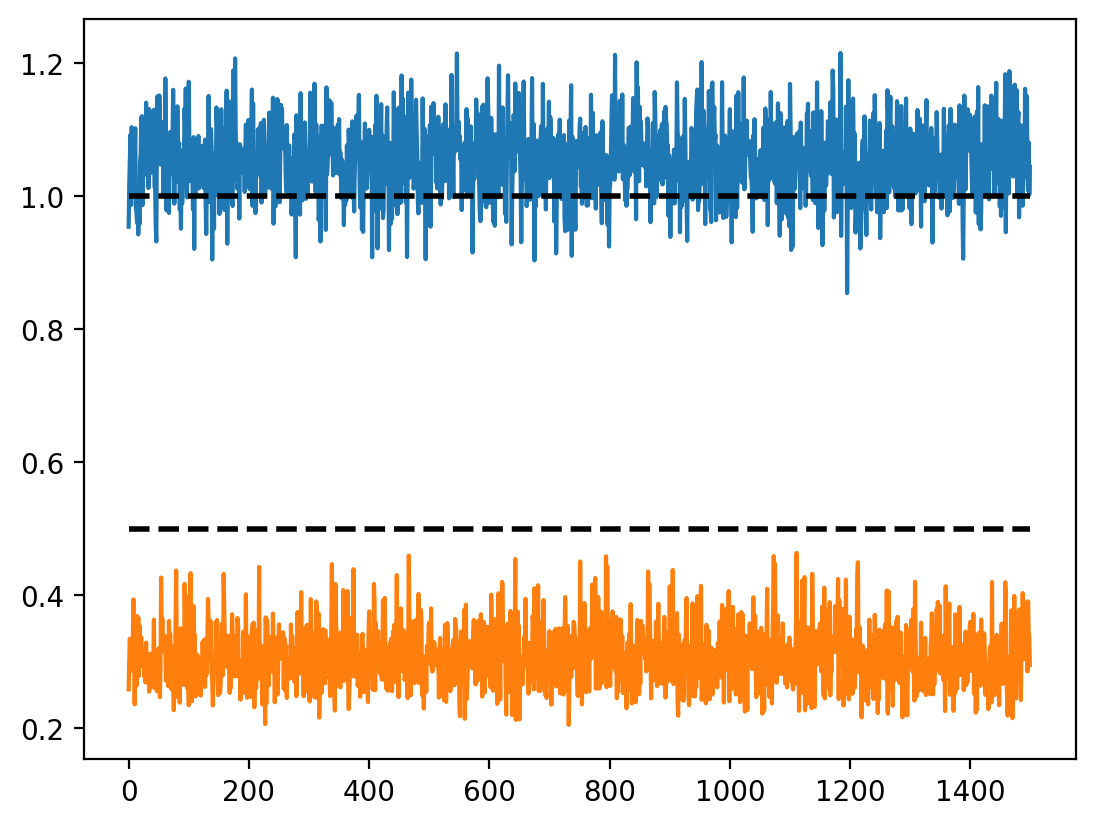

In [8]:
thin = int(np.round_(acor.acor(samples[:,0])[0])) # acor tells autocorrelation length of an array
print('Taking every n = ' + str(thin) + ' samples based on ac length.') # to use just independent samples
print('Burning first n = ' + str(500) + ' samples.')

plt.plot(samples[500::thin,0]); # remove first 500 to remove burn- in phase (first col, mu)
plt.plot(samples[500::thin,1]); # remove first 500 to remove burn- in phase (second col, sigma)

# injected values
plt.hlines(1.0, 0.0, 1500, color='k', lw=2, ls='dashed');
plt.hlines(0.5, 0.0, 1500, color='k', lw=2, ls='dashed');

# ideally the trace plot would go around the dashed lines- expectations from data
# if not, indicative of biases

**Gibbs sampling is awesome...provided that you can work out the analytic conditional posteriors as standard distribution forms.** 

But even if you can't, all is not lost. You can get inventive by embedding a short Metropolis-Hastings block within the Gibbs algorithm. For example, if there are parameters for which you can not directly draw from the conditional, then your Gibbs step for that parameter could be a short Metropolis-Hastings MCMC run. 

The goal is to run this sufficiently long enough that you have drawn a single quasi-independent random sample from the parameter posterior conditional distribution, with all other parameters fixed. You can then proceed through the remainder of your Gibbs steps as normal. 

##  Practical Evidence Evaluation & Model Selection <a class="anchor" id="two"></a>

We've discussed Bayesian parameter estimation algorithms in detail. But what about evidence evaluation and model comparison? We already have the AIC and BIC as proxies. Grid-based methods for integrating the likelihood $\times$ prior are far too crude. 

There are some further numerical techniques that we'll briefly discuss, before looking at examples of **Nested Sampling** algorithms to compute the Bayesian evidence. 

### Savage-Dickey Density Ratio

This is great for when we want to compare models that have nested parameters, e.g. (1) a model with just noise, and (2) a model with a signal and noise. We need to be able to identify a parameter in the signal model that acts as an amplitude, $A$, that can effectively switch the signal off when it is zero. 

Thus $p_1(d|n) = p_2(d|A=0,n)$.

With MCMC sampling we can map out the full parameter posterior distribution of model (2). We need to make sure we get good mixing and exploration of the parameter $A$ so that we can reconstruct its posterior density at $A=0$. 

The Bayes factor of Model $2$ (signal and noise) versus Model $1$ (noise alone) can be computed using the **[Savage-Dickey Density Ratio](https://www.jstor.org/stable/2958475?casa_token=Dc8wjaKRj5UAAAAA%3A4IhKgqNXc4jpan6hRxW7tBpXTI4i2236BulPTRxj4FcivD988vqJw-N75Dtw7z4Lh3YtPsDIceS8NDtIXAIRIO1T227h9VYZ2prQpwb46WLBB0GGz8w&seq=1#metadata_info_tab_contents)** approximation,

$$ \mathcal{B} = \frac{\mathcal{Z}_2}{\mathcal{Z}_1} = \frac{p(A=0)}{p(A=0|d,n)}$$

which is the prior density at $A=0$ divided by the conditional posterior density at $A=0$. We can easily compute the latter by making a histogram of posterior samples in $A$ and reading off the normalized pdf at $A=0$.

### Product-space Sampling

Product-space sampling sounds fancy, but is super easy. In this type of model comparison, we never explicitly try to compute the Bayesian evidence. 

- We run a big MCMC chain that includes all parameters of all models, in addition to a model indexing parameter, $n$. 
- We define distinct ranges for this parameter, such that in certain sampling ranges it will trigger one of the model likelihoods to be used, e.g. if $-0.5<n<0.5$ use the likelihood for model $1$. 
- After sampling sufficiently long, the MCMC chain will spend different amounts of time in differnt regions of $n$ in proportion to the Bayesian odds ratio. 
- Hence, the ratio of samples in model sub-ranges of $n$ gives the Bayesian odds ratio. Simple!
- We use this alot in PTA GW searches, see [https://arxiv.org/abs/1801.02617](https://arxiv.org/abs/1801.02617), [https://arxiv.org/abs/2009.04496](https://arxiv.org/abs/2009.04496), and [https://arxiv.org/abs/2006.04810](https://arxiv.org/abs/2006.04810). 
- Refs [here](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1995.tb02042.x) and [here](https://amstat.tandfonline.com/doi/abs/10.1198/10618600152627924?casa_token=Kgpt2ZvdMrcAAAAA%3Al5JB7EitQ7MjPmxBObu2XJXocZCE1tI2-ZAceCwBjJOi2TRajF7SaxFcQjo1Nn5AF9q6vKhkxpBd&#.YEZH4F1KiLo).

### Thermodynamic Integration

This technique is pretty fancy, and is derived from analogies with thermodynamics. It is used for exact calculation of the Bayesian evidence. 

- Many MCMC chains are launched in parallel. However, their likelihoods differ slightly in their "temperature", $T$. We actually use the inverse temperature $\beta=1/T$ when writing the math. The temperature of a chain is used to modify the likelihood as follows, where 

$$ p(d|\theta)_\beta = p(d|\theta)^\beta = p(d|\theta)^{1/T}.$$

- Thus only the $T=0$ chain corresponds to the actual model likelihood. 
- But the other temperature chains have the effect of taking higher and higher roots of the likelihood, smoothing it out and making it more similar to the original prior. 
- These high temperature chains explore the parameter volume well, communicate back to the $T=0$ chain, and improve MCMC mixing. 
- Crucially, we can also use them in evidence computation:

$$ \ln\mathcal{Z} = \int_0^1 \langle \ln p(d|\theta)\rangle_\beta\, d\beta, $$

where we take the mean log-likelihood of each $\beta$ chain, then sum these over all temperatures to get the log-evidence. Refs [here](https://www.jstor.org/stable/2676756?casa_token=nGU-oa0w6lQAAAAA%3A8UNqj0_rBP7aZ4vocZ_NzbxKhre4WvzhbNOs_TTI_FfexQmppcxQSlxaO5PCHPZNAw9fZUmy4rPeXLe_CVJgAD2AYR6qS8D6xQDicpc1R45ZhjEtOV4&seq=1#metadata_info_tab_contents), and [here](https://link.springer.com/content/pdf/10.1007/BF01406511.pdf).

### Nested Sampling

Nested sampling is a very different MCMC method from Metropolis-Hastings or even Gibbs approaches. 

- One starts with many points spread throughout the prior volume.
- The points are ranked in terms of their likelihood.
- The lowest ranked point is removed, and a higher likelihood point is randomly added.
- This is repeated, until the cluster of points climbs up the likelihood surface, accumulating Bayesian evidence information along the way. 

The prior volume is defined as $dX = p(\theta)d^n\theta$ such that $X(\lambda) = \int_{p(d|\theta)>\lambda}p(\theta)d^n\theta$, where the integral is over the model parameter region that exceeds the iso-likelihood contour $p(d|\theta)=L(\theta)=\lambda$.

This transforms the evidence integral into 

$$\mathcal{Z} = \int p(d|\theta)p(\theta)d^n\theta = \int_0^1 L(X)dX.$$

There are several popular packages that perform nested sampling, and not only do they all compute the Bayesian evidence but they also produce posterior samples as a by-product. 

By far the most historically well known is [`MultiNest`](https://github.com/rjw57/MultiNest) and its Python wrapper [`PyMultiNest`](https://johannesbuchner.github.io/PyMultiNest/). It used to be (and may still be) a bit of a pain to install though (there is C and Fortran involved). Refs [here](https://ui.adsabs.harvard.edu/abs/2004AIPC..735..395S/abstract), and [here](https://academic.oup.com/mnras/article/398/4/1601/981502?login=true).


So while this is the big one, there seem to be other more pythonic implementations now on the market. Let's look at those.

### Dynesty <a class="anchor" id="twoa"></a>

https://arxiv.org/abs/1904.02180

![](https://github.com/joshspeagle/dynesty/blob/master/docs/images/title.gif?raw=true)

This example comes from the [dynesty](https://arxiv.org/abs/1904.02180) ["crash course"](https://dynesty.readthedocs.io/en/latest/crashcourse.html). We define our likelihood to be a $3$D correlated multivariate Gaussian distribution, and our prior to be uniform in each dimension from $-10$ to $10$.

In [9]:
import dynesty

# Define the dimensionality of our problem.
ndim = 3

# Define our 3-D correlated multivariate normal likelihood.
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.95  # set off-diagonal terms
Cinv = np.linalg.inv(C)  # define the inverse (i.e. the precision matrix)
lnorm = -0.5 * (np.log(2 * np.pi) * ndim +
                np.log(np.linalg.det(C)))  # ln(normalization)

def loglike(x):
    """The log-likelihood function."""

    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# Define our uniform prior.
def ptform(u):
    """Transforms samples `u` drawn from the unit cube to samples to those
    from our uniform prior within [-10., 10.) for each variable."""

    return 10. * (2. * u - 1.)

Run the sampler. *(You may get some warnings about messages not being able to write out anymore because the buffer was exceeded. Don't worry. Just check the circle in the top right of your notebook to see when it goes from filled to hollow to show that the cell is finished.)*

In [10]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike, ptform, ndim)
sampler.run_nested()
sresults = sampler.results

iter: 4801 | +500 | bound: 8 | nc: 1 | ncall: 23844 | eff(%): 22.708 | loglstar:   -inf < -0.295 <    inf | logz: -9.112 +/-  0.129 | dlogz:  0.001 >  0.509                                          

In [11]:
## "Dynamic" nested sampling.
# COME BACK and RUN THIS IF YOU HAVE TIME AT THE END. 

#dsampler = dynesty.DynamicNestedSampler(loglike, ptform, ndim)
#dsampler.run_nested()
#dresults = dsampler.results

You've just estimated the Bayesian evidence and posterior. Plot the results. These figures will have an $x$-axis that is $-\ln X$ which is a bit confusing to think about to begin with, but remember that we are moving up the likelihood contours when going from left to right on the graphs.

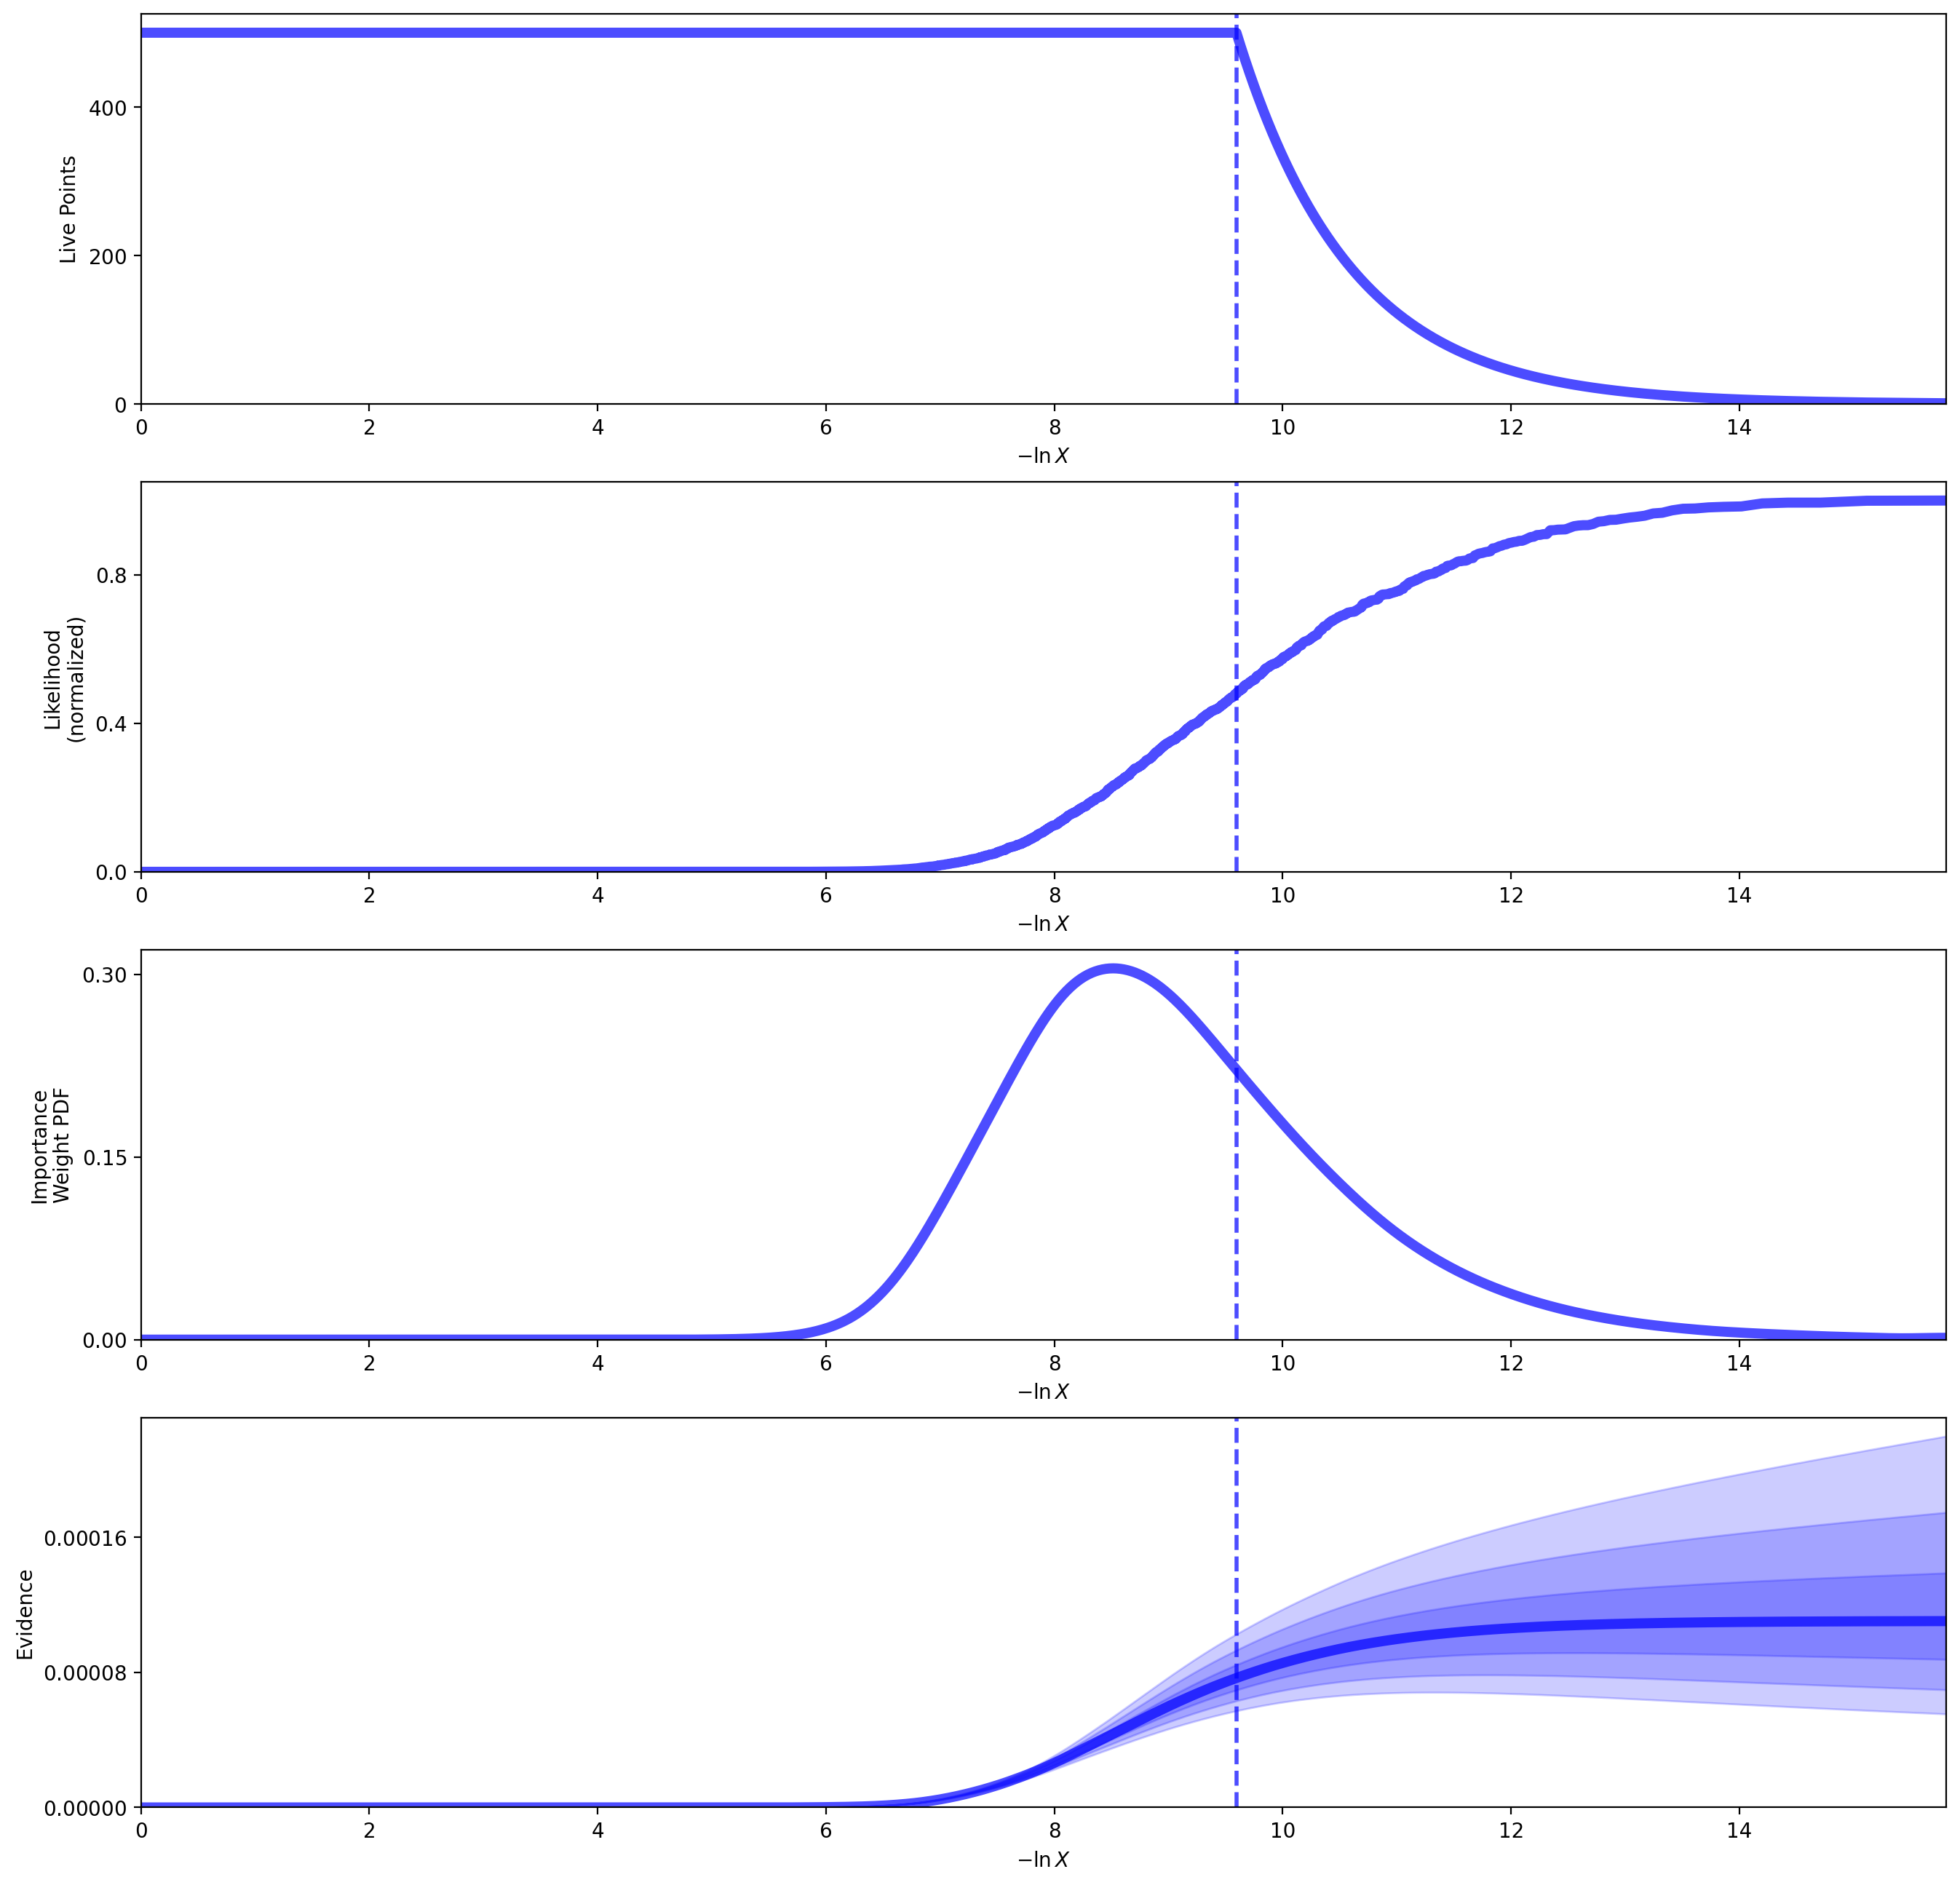

In [12]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(sresults)

Plot parameter traces and 1-D marginalized posteriors. On the left panels, you'll see that the live points started out scattereed across the prior volume, then move inwards as the sampler climbs the likelihood.

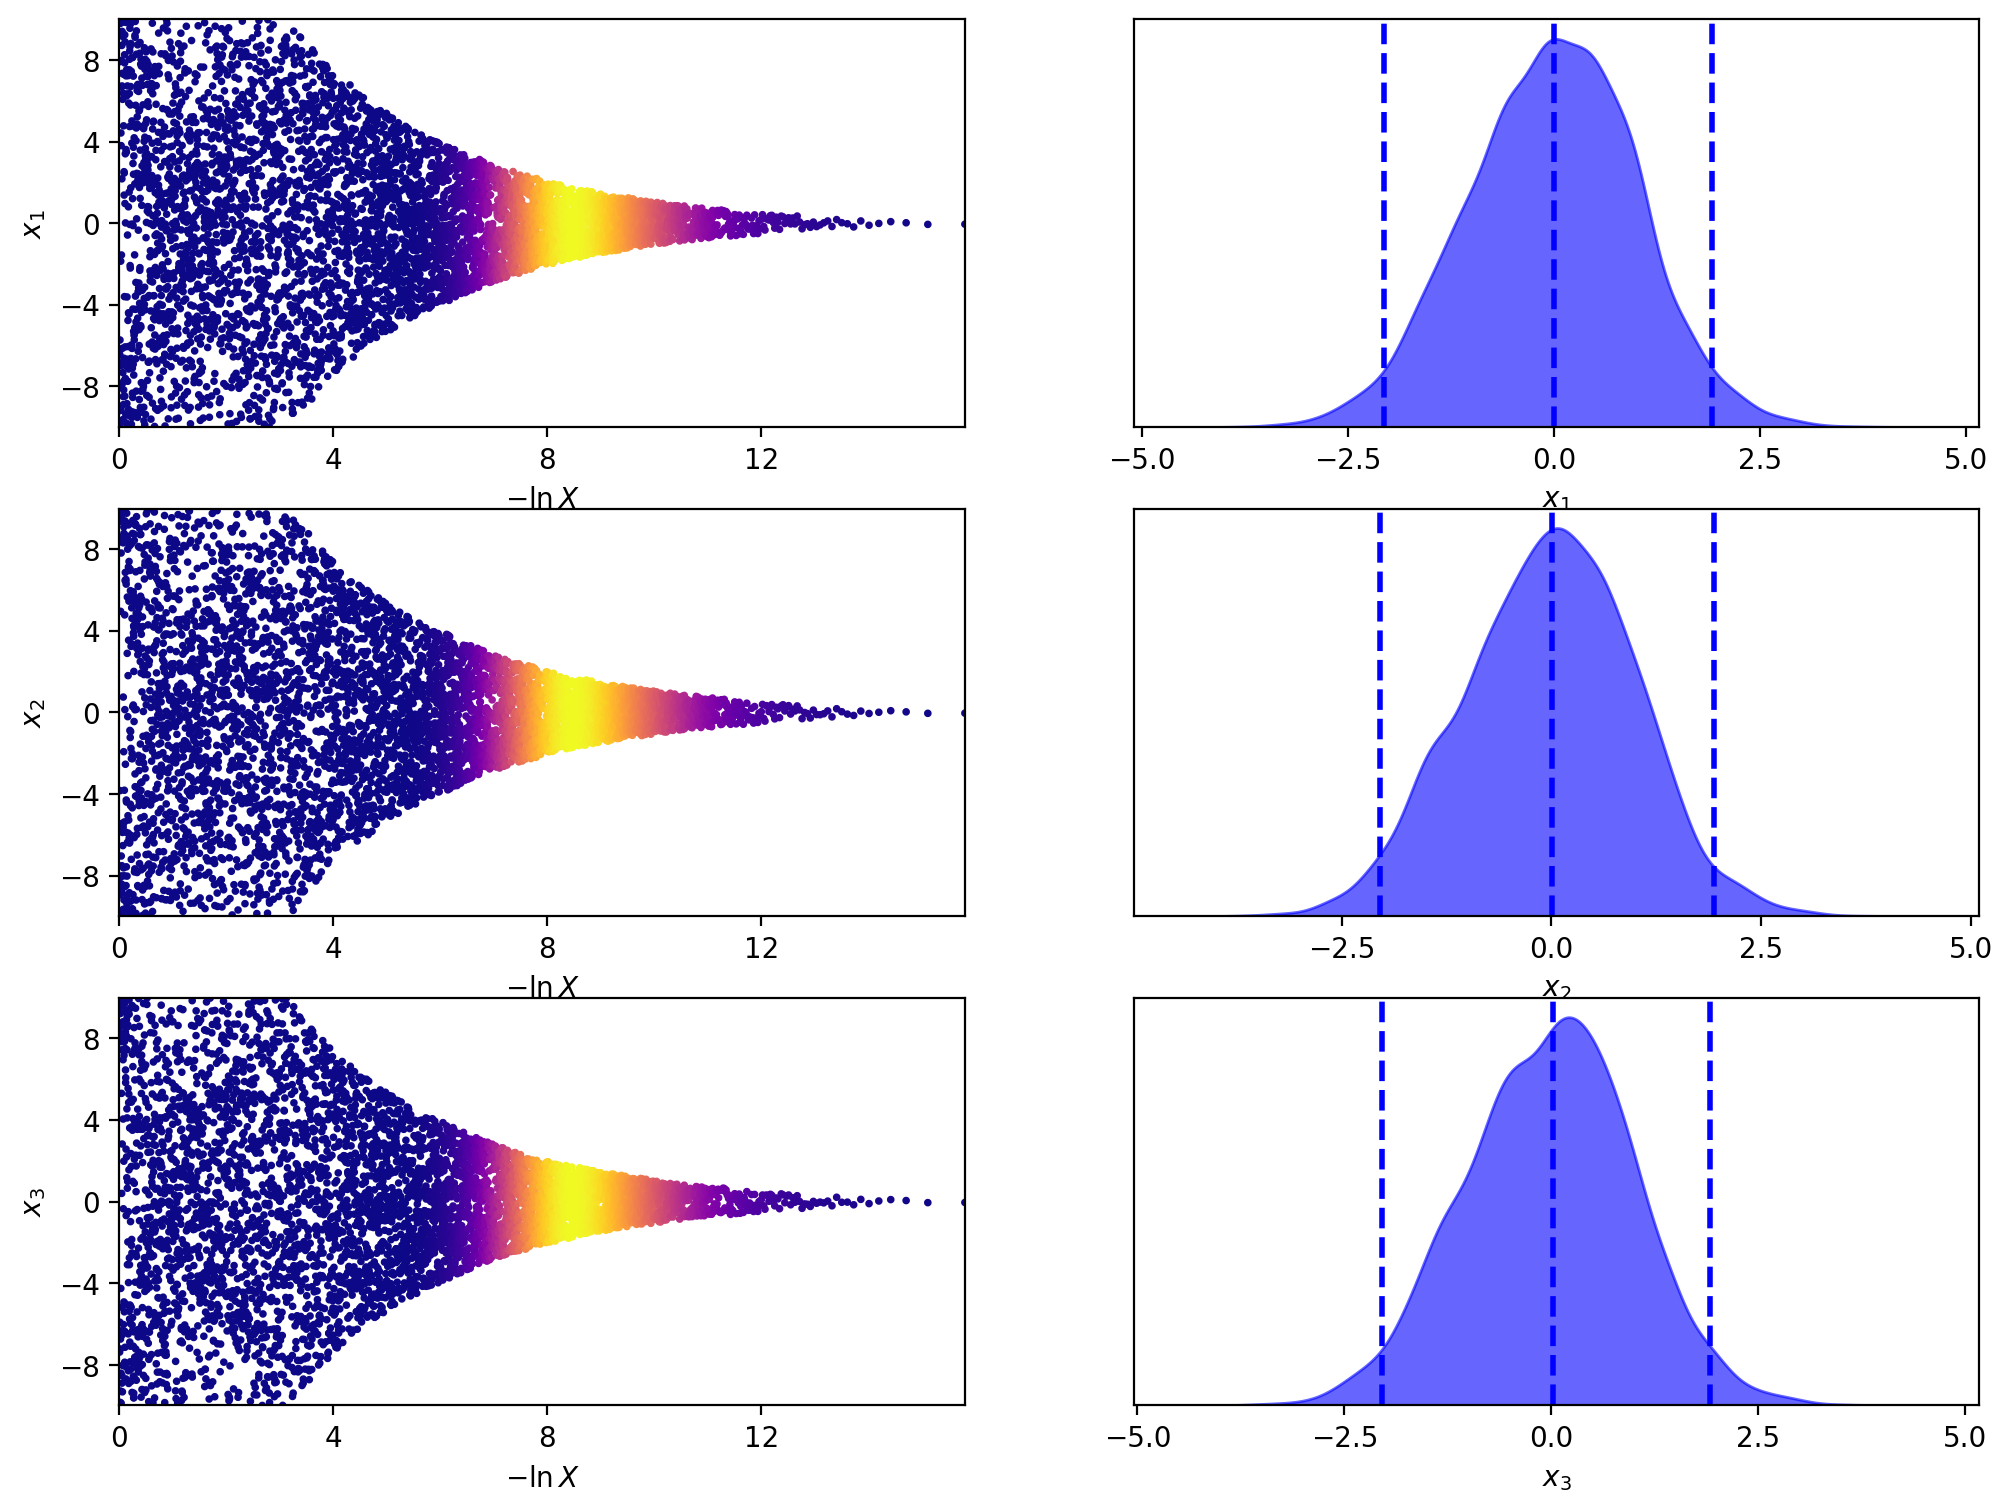

In [13]:
tfig, taxes = dyplot.traceplot(sresults)

Plot the 2-D marginalized posteriors using `dynesty` routines. (But you could also use `corner` if you wish).

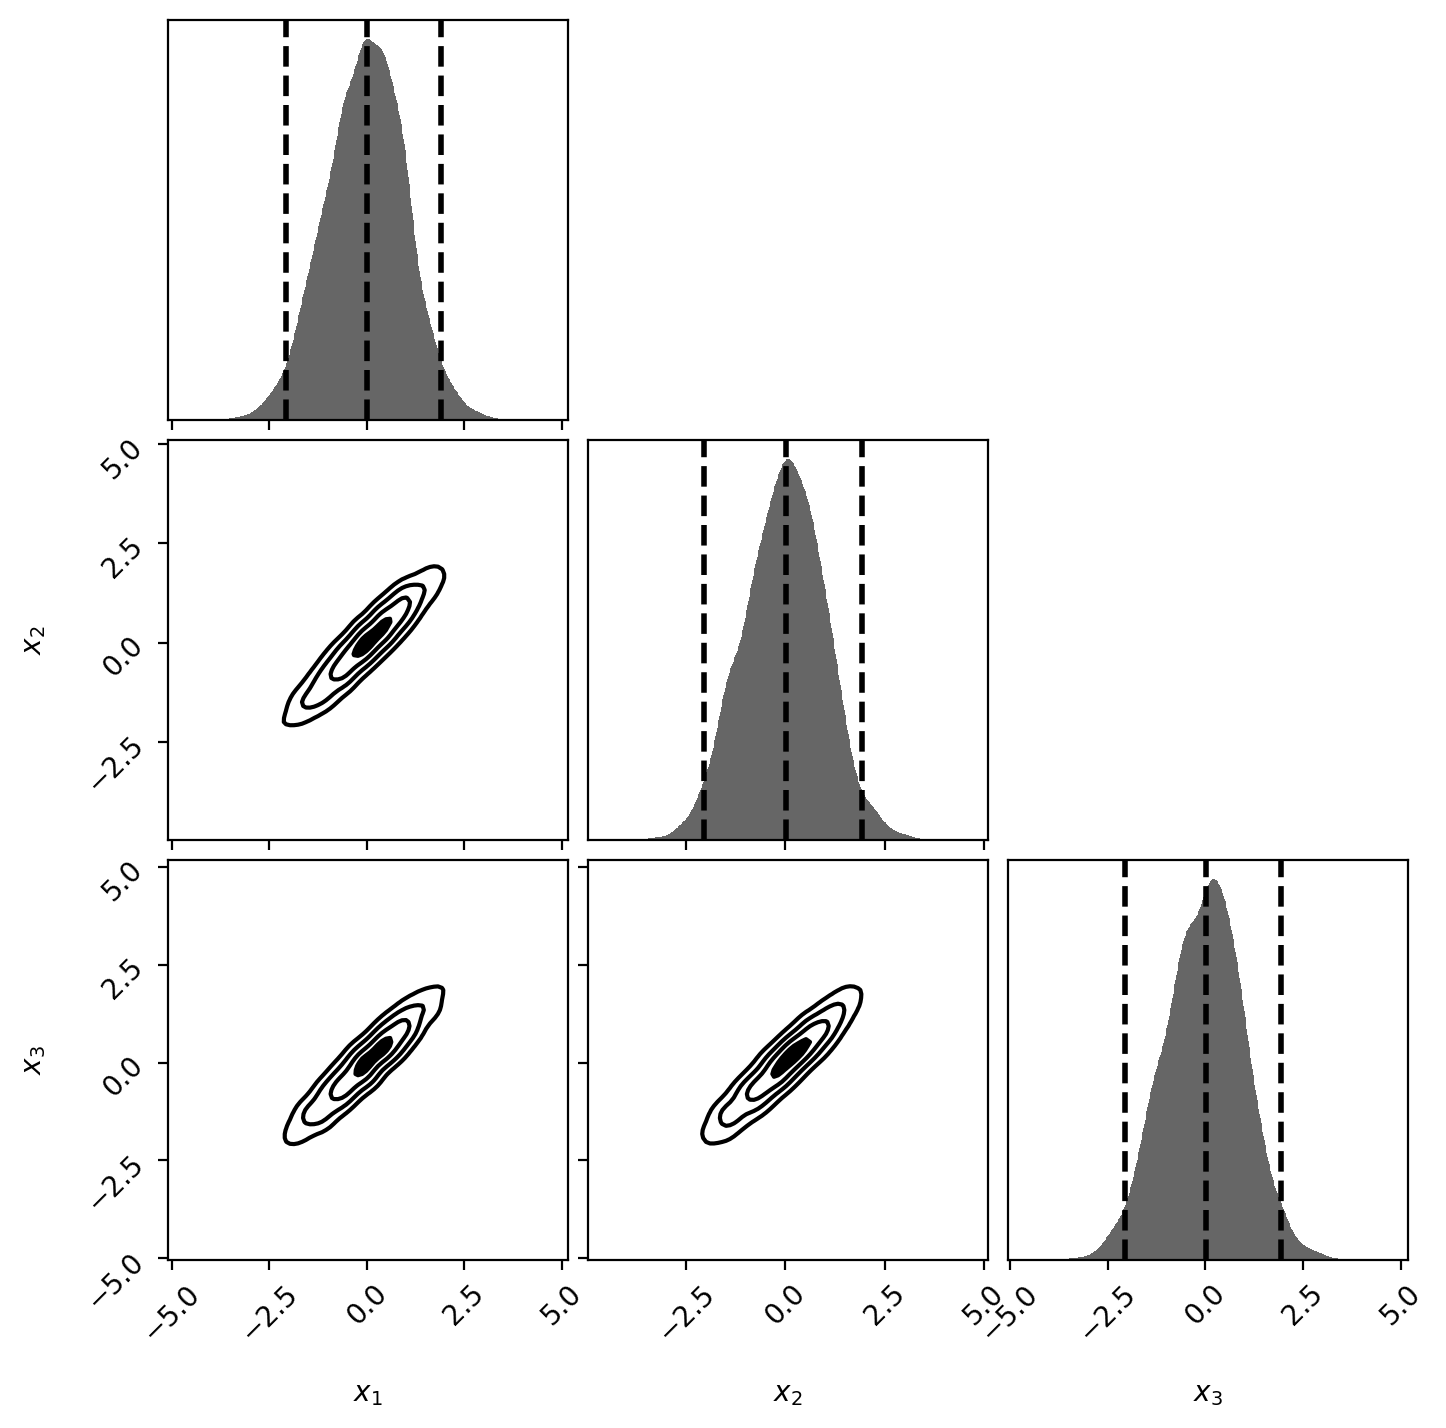

In [14]:
cfig, caxes = dyplot.cornerplot(sresults)